<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->


# Step 5: `Dataset`s and `DataLoader`

One of the most critical steps for model training and inference is loading the data: without data you can't do Machine Learning! In this tutorial you will use the Gluon API to define a Dataset and use a DataLoader to iterate through the dataset in mini-batches.

In [1]:
import mxnet as mx
import os
import time
import tarfile

## Introduction to `Dataset`s

Dataset objects are used to represent collections of data, and include methods to load and parse the data (that is often stored on disk). Gluon has a number of different `Dataset` classes for working with image data straight out-of-the-box, but you'll use the ArrayDataset to introduce the idea of a `Dataset`.

You will first start by generating random data `X` (with 3 variables) and corresponding random labels `y` to simulate a typical supervised learning task. You will generate 10 samples and pass them all to the `ArrayDataset`.

In [2]:
mx.np.random.seed(42) # Fix the seed for reproducibility
X = mx.np.random.uniform(size=(10, 3))
y = mx.np.random.uniform(size=(10, 1))
dataset = mx.gluon.data.dataset.ArrayDataset(X, y)

A key feature of a `Dataset` is the __*ability to retrieve a single sample given an index*__. Our random data and labels were generated in memory, so this `ArrayDataset` doesn't have to load anything from disk, but the interface is the same for all `Dataset`'s.

In [3]:
sample_idx = 4
sample = dataset[sample_idx]

assert len(sample) == 2
assert sample[0].shape == (3, )
assert sample[1].shape == (1, )
print(sample)

(array([0.74707687, 0.37641123, 0.46362457]), array([0.35440788]))


You get a tuple of a data sample and its corresponding label, which makes sense because you passed the data `X` and the labels `y` in that order when you instantiated the `ArrayDataset`. You don't usually retrieve individual samples from `Dataset` objects though (unless you're quality checking the output samples). Instead you use a `DataLoader`.

## Introduction to `DataLoader`

A DataLoader is used to create mini-batches of samples from a Dataset, and provides a convenient iterator interface for looping these batches. It's typically much more efficient to pass a mini-batch of data through a neural network than a single sample at a time, because the computation can be performed in parallel. A required parameter of `DataLoader` is the size of the mini-batches you want to create, called `batch_size`.

Another benefit of using `DataLoader` is the ability to easily load data in parallel using multiprocessing. You can set the `num_workers` parameter to the number of CPUs available on your machine for maximum performance, or limit it to a lower number to spare resources.

In [4]:
from multiprocessing import cpu_count
CPU_COUNT = cpu_count()

data_loader = mx.gluon.data.DataLoader(dataset, batch_size=5, num_workers=CPU_COUNT)

for X_batch, y_batch in data_loader:
    print("X_batch has shape {}, and y_batch has shape {}".format(X_batch.shape, y_batch.shape))

X_batch has shape (5, 3), and y_batch has shape (5, 1)
X_batch has shape (5, 3), and y_batch has shape (5, 1)


You can see 2 mini-batches of data (and labels), each with 5 samples, which makes sense given that you started with a dataset of 10 samples. When comparing the shape of the batches to the samples returned by the `Dataset`,you've gained an extra dimension at the start which is sometimes called the batch axis.

Our `data_loader` loop will stop when every sample of `dataset` has been returned as part of a batch. Sometimes the dataset length isn't divisible by the mini-batch size, leaving a final batch with a smaller number of samples. `DataLoader`'s default behavior is to return this smaller mini-batch, but this can be changed by setting the `last_batch` parameter to `discard` (which ignores the last batch) or `rollover` (which starts the next epoch with the remaining samples).

## Machine learning with `Dataset`s and `DataLoader`s

You will often use a few different `Dataset` objects in your Machine Learning project. It's essential to separate your training dataset from testing dataset, and it's also good practice to have validation dataset (a.k.a. development dataset) that can be used for optimising hyperparameters.

Using Gluon `Dataset` objects, you define the data to be included in each of these separate datasets. It's simple to create your own custom `Dataset` classes for other types of data. You can even use included `Dataset` objects for common datasets if you want to experiment quickly; they download and parse the data for you! In this example you use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset from Zalando Research.

Many of the image `Dataset`'s accept a function (via the optional `transform` parameter) which is applied to each sample returned by the `Dataset`. It's useful for performing data augmentation, but can also be used for more simple data type conversion and pixel value scaling as seen below.

In [5]:
def transform(data, label):
    data = data.astype('float32')/255
    return data, label

train_dataset = mx.gluon.data.vision.datasets.FashionMNIST(train=True).transform(transform)
valid_dataset = mx.gluon.data.vision.datasets.FashionMNIST(train=False).transform(transform)

Data type: float32
Label: 8
Label description: Bag


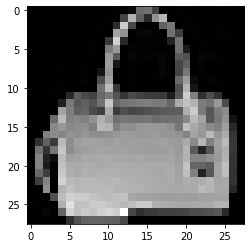

In [6]:
from matplotlib.pylab import imshow

sample_idx = 234
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]
label_desc = {0:'T-shirt/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'}

print("Data type: {}".format(data.dtype))
print("Label: {}".format(label))
print("Label description: {}".format(label_desc[label.item()]))
imshow(data[:,:,0].asnumpy(), cmap='gray')

![datasets fashion mnist bag](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/gluon/datasets/fashion_mnist_bag.png)

When training machine learning models it is important to shuffle the training samples every time you pass through the dataset (i.e. each epoch). Sometimes the order of your samples will have a spurious relationship with the target variable, and shuffling the samples helps remove this. With DataLoader it's as simple as adding `shuffle=True`. You don't need to shuffle the validation and testing data though.

In [7]:
batch_size = 32
train_data_loader = mx.gluon.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=CPU_COUNT)
valid_data_loader = mx.gluon.data.DataLoader(valid_dataset, batch_size, num_workers=CPU_COUNT)

With both `DataLoader`s defined, you can now train a model to classify each image and evaluate the validation loss at each epoch. See the next tutorial for how this is done.

# Using own data with included `Dataset`s

Gluon has a number of different Dataset classes for working with your own image data straight out-of-the-box. You can get started quickly using the mxnet.gluon.data.vision.datasets.ImageFolderDataset which loads images directly from a user-defined folder, and infers the label (i.e. class) from the folders.

Here you will run through an example for image classification, but a similar process applies for other vision tasks. If you already have your own collection of images to work with you should partition your data into training and test sets, and place all objects of the same class into seperate folders. Similar to:

```
./images/train/car/abc.jpg
./images/train/car/efg.jpg
./images/train/bus/hij.jpg
./images/train/bus/klm.jpg
./images/test/car/xyz.jpg
./images/test/bus/uvw.jpg
```


You can download the Caltech 101 dataset if you don't already have images to work with for this example, but please note the download is 126MB.

In [8]:
data_folder = "data"
dataset_name = "101_ObjectCategories"
archive_file = "{}.tar.gz".format(dataset_name)
archive_path = os.path.join(data_folder, archive_file)
data_url = "https://s3.us-east-2.amazonaws.com/mxnet-public/"

if not os.path.isfile(archive_path):
    mx.test_utils.download("{}{}".format(data_url, archive_file), dirname = data_folder)
    print('Extracting {} in {}...'.format(archive_file, data_folder))
    tar = tarfile.open(archive_path, "r:gz")
    tar.extractall(data_folder)
    tar.close()
    print('Data extracted.')

After downloading and extracting the data archive, you have two folders: `data/101_ObjectCategories` and `data/101_ObjectCategories_test`. You can then load the data into separate training and testing  ImageFolderDatasets.

training_path = os.path.join(data_folder, dataset_name)
testing_path = os.path.join(data_folder, "{}_test".format(dataset_name))

You instantiate the ImageFolderDatasets by providing the path to the data, and the folder structure will be traversed to determine which image classes are available and which images correspond to each class. You must take care to ensure the same classes are both the training and testing datasets, otherwise the label encodings can get muddled.

Optionally, you can pass a `transform` parameter to these `Dataset`'s as you've seen before.

In [9]:
training_path='./data/101_ObjectCategories'
testing_path='./data/101_ObjectCategories_test'
train_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(training_path)
test_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(testing_path)

Samples from these datasets are tuples of data and label. Images are loaded from disk, decoded and optionally transformed when the `__getitem__(i)` method is called (equivalent to `train_dataset[i]`).

As with the Fashion MNIST dataset the labels will be integer encoded. You can use the `synsets` property of the ImageFolderDatasets to retrieve the original descriptions (e.g. `train_dataset.synsets[i]`).

Data type: uint8
Label: 1
Label description: Faces_easy


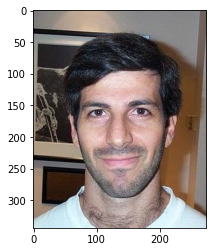

In [10]:
sample_idx = 539
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

print("Data type: {}".format(data.dtype))
print("Label: {}".format(label))
print("Label description: {}".format(train_dataset.synsets[label]))
assert label == 1

imshow(data.asnumpy(), cmap='gray')

![datasets caltech101 face](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/gluon/datasets/caltech101_face.png)<!--notebook-skip-line-->

# Using your own data with custom `Dataset`s

Sometimes you have data that doesn't quite fit the format expected by the included Datasets. You might be able to preprocess your data to fit the expected format, but it is easy to create your own dataset to do this.

All you need to do is create a class that implements a `__getitem__` method, that returns a sample (i.e. a tuple of mx.np.ndarrays).

# New in MXNet 2.0: faster C++ backend dataloaders

As part of an effort to speed up the current data loading pipeline using gluon dataset and dataloader, a new dataloader was created that uses only a C++ backend and avoids potentially slow calls to Python functions.

See [original issue](https://github.com/apache/incubator-mxnet/issues/17269), [pull request](https://github.com/apache/incubator-mxnet/pull/17464) and [implementation](https://github.com/apache/incubator-mxnet/pull/17841).

The current data loading pipeline is the major bottleneck for many training tasks. The flow can be summarized as:

- `Dataset.__getitem__`
- `Transform.__call__()/forward()`
- `Batchify`
- (optional communicate through shared_mem)
- `split_and_load(devices)`
- training on GPUs

Performance concerns include slow python dataset/transform functions, multithreading issues due to global interpreter lock, Python multiprocessing issues due to speed, and batchify issues due to poor memory management.

This new dataloader provides: 
- common C++ batchify functions that are split and context aware
- a C++ MultithreadingDataLoader which inherit the same arguments as gluon.data.DataLoader but use MXNet internal multithreading rather than python multiprocessing.
- fallback to python multiprocessing whenever the dataset is not fully supported by backend (e.g., there are custom python datasets) in the case that:
    - the transform is not fully hybridizable
    - batchify is not fully supported by backend

Users can continue to with the traditional gluon.data.Dataloader and the C++ backend will be applied automatically. The 'try_nopython' default is 'Auto', which detects whether the C++ backend is available given the dataset and transforms. 

Here you will show a performance increase on a t3.2xl instance for the CIFAR10 dataset with the C++ backend.

## Using the C++ backend:

In [11]:
cpp_dl = mx.gluon.data.DataLoader(
    mx.gluon.data.vision.CIFAR10(train=True, transform=None), batch_size=32, num_workers=2,try_nopython=True)

In [12]:
start = time.time()
for _ in range(3):
    print(len(cpp_dl))
    for _ in cpp_dl:
        pass
print('Elapsed time for backend dataloader:', time.time() - start)

1563


1563


1563


Elapsed time for backend dataloader: 7.0280585289001465


## Using the Python backend:

In [13]:
dl = mx.gluon.data.DataLoader(
    mx.gluon.data.vision.CIFAR10(train=True, transform=None), batch_size=32, num_workers=2,try_nopython=False)

In [14]:
start = time.time()
for _ in range(3):
    print(len(dl))
    for _ in dl:
        pass
print('Elapsed time for python dataloader:', time.time() - start)

1563


1563


1563


Elapsed time for python dataloader: 8.901087760925293


## Next Steps

Now that you have some experience with MXNet's datasets and dataloaders, it's time to use them for [Step 6: Training a Neural Network](./6-train-nn.ipynb).